In [450]:
## Imports
import torch
import torchvision ## Contains some utilities for working with the image data
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
#%matplotlib inline
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import os
import numpy as np
import pandas as pd




In [451]:
class CustomDatasetFromDepthImages(Dataset):
    def __init__(self, csv_path, img_path):
        """
        Args:
            csv_path (string): path to csv file
            img_path (string): path to the folder where images are
            transform: pytorch transforms for transforms and tensor conversion
        """
        # Transforms
        self.to_tensor = transforms.ToTensor()
        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=None)
        # First column contains the image paths
        self.image_arr = np.asarray(self.data_info.iloc[1:, 0])
        # Second column is the labels
        self.label_arr = np.asarray(self.data_info.iloc[1:, 1])
        # Calculate len
        self.data_len = len(self.data_info.index) - 2 

        self.img_path = img_path

    def __getitem__(self, index):
        # Get image name from the pandas df
        single_image_name = self.img_path + '/' + self.image_arr[index]
        # Open image
        img_as_img = np.load(single_image_name)
        img_as_img /= 10000.0
        # Transform image to tensor
        img_as_tensor = torch.from_numpy(img_as_img.astype('float32'))

        # Get label(class) of the image based on the cropped pandas column
        single_image_label = self.label_arr[index]

        return (img_as_tensor, int(single_image_label))

    def __len__(self):
        return self.data_len
    

In [452]:
DATAPATH = '/home/alex/Documents/datasets/VisualPlanerData/iter_1/out.csv'
DATAPATHIMAGES = '/home/alex/Documents/datasets/VisualPlanerData/iter_1'
custom_dataset =  CustomDatasetFromDepthImages(DATAPATH, DATAPATHIMAGES)
custom_dataset.data_len

9643

In [453]:
print(custom_dataset[0])
# plt.imshow(image, cmap = 'gray')
# print('Label:', label)

(tensor([0.0273, 0.0129, 1.0000, 0.0243, 0.0241, 0.0248, 0.0264, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0406, 0.0409, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0434, 0.0262, 0.0255, 0.0261, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0124, 0.0125, 0.0125, 0.0129, 0.0247, 0.0246, 0.0637,
        0.0420, 0.0378, 0.0388, 0.0570, 0.0606, 0.0224]), 2)


In [454]:
## MNIST dataset(images and labels)
# mnist_dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor())
# print(mnist_dataset)


In [455]:

image_tensor, label = custom_dataset[0]
print(image_tensor.shape, label)

torch.Size([42]) 2


In [456]:

print(image_tensor)
print(torch.max(image_tensor), torch.min(image_tensor))

tensor([0.0273, 0.0129, 1.0000, 0.0243, 0.0241, 0.0248, 0.0264, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.0406, 0.0409, 1.0000,
        1.0000, 1.0000, 1.0000, 0.0434, 0.0262, 0.0255, 0.0261, 1.0000, 1.0000,
        1.0000, 1.0000, 0.0124, 0.0125, 0.0125, 0.0129, 0.0247, 0.0246, 0.0637,
        0.0420, 0.0378, 0.0388, 0.0570, 0.0606, 0.0224])
tensor(1.) tensor(0.0124)


In [457]:
k = 0.8
train_data_len = round(custom_dataset.data_len * k)
validation_data_len = round(custom_dataset.data_len * (1-k))
train_data, validation_data = random_split(custom_dataset, [train_data_len, validation_data_len])
## Print the length of train and validation datasets
print("length of Train Datasets: ", len(train_data))
print("length of Validation Datasets: ", len(validation_data))

length of Train Datasets:  7714
length of Validation Datasets:  1929


In [458]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size, shuffle = True)
val_loader = DataLoader(validation_data, batch_size, shuffle = False)

In [459]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return(torch.tensor(torch.sum(preds == labels).item()/ len(preds)))

In [473]:
input_size = 42
num_classes = 6

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 42)
        self.linear2 = nn.Linear(42, 30)
        self.linear3 = nn.Linear(30, 15)
        self.linear4 = nn.Linear(15, num_classes)

        self.act = nn.SELU()
    
    def forward(self, xb):

        out = self.linear1(xb)
        out = self.act(out)
        out = self.linear2(out)
        out = self.act(out)
        out = self.linear3(out)
        out = self.act(out)
        out = self.linear4(out)
        return(out)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) ## Generate predictions
        loss = F.cross_entropy(out, labels) ## Calculate the loss
        return(loss)
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return({'val_loss':loss, 'val_acc': acc})
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return({'val_loss': epoch_loss.item(), 'val_acc' : epoch_acc.item()})
    
    def epoch_end(self, epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
        
    
model = MnistModel()



In [474]:
# print(type(train_data))
# custom_dataset[0][0]
model.forward(custom_dataset[214][0]).size()
# custom_dataset[0][0].dtype

torch.Size([6])

In [475]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return(model.validation_epoch_end(outputs))

def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        ## Training Phas
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        ## Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return(history)

In [476]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 1.7088547945022583, 'val_acc': 0.1810980886220932}

In [477]:
history1 = fit(10000, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.2391, val_acc: 0.6175
Epoch [1], val_loss: 1.2037, val_acc: 0.6326
Epoch [2], val_loss: 1.1525, val_acc: 0.6253
Epoch [3], val_loss: 1.1347, val_acc: 0.6311
Epoch [4], val_loss: 1.1150, val_acc: 0.6463
Epoch [5], val_loss: 1.0874, val_acc: 0.6458
Epoch [6], val_loss: 1.0712, val_acc: 0.6497
Epoch [7], val_loss: 1.0734, val_acc: 0.6565
Epoch [8], val_loss: 1.0392, val_acc: 0.6565
Epoch [9], val_loss: 1.0162, val_acc: 0.6629
Epoch [10], val_loss: 0.9988, val_acc: 0.6682
Epoch [11], val_loss: 0.9661, val_acc: 0.6736
Epoch [12], val_loss: 0.9403, val_acc: 0.6780
Epoch [13], val_loss: 0.9218, val_acc: 0.6844
Epoch [14], val_loss: 0.9153, val_acc: 0.6951
Epoch [15], val_loss: 0.8903, val_acc: 0.6941
Epoch [16], val_loss: 0.8687, val_acc: 0.7010
Epoch [17], val_loss: 0.8700, val_acc: 0.7005
Epoch [18], val_loss: 0.8573, val_acc: 0.7102
Epoch [19], val_loss: 0.8934, val_acc: 0.6990
Epoch [20], val_loss: 0.8393, val_acc: 0.7185
Epoch [21], val_loss: 0.8517, val_acc: 0.701

KeyboardInterrupt: 

In [407]:
history2 = fit(1000, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.6952, val_acc: 0.7827
Epoch [1], val_loss: 1.6815, val_acc: 0.7943
Epoch [2], val_loss: 1.6923, val_acc: 0.7932
Epoch [3], val_loss: 1.6699, val_acc: 0.7896
Epoch [4], val_loss: 1.6808, val_acc: 0.7944
Epoch [5], val_loss: 1.7298, val_acc: 0.7818
Epoch [6], val_loss: 1.6911, val_acc: 0.7941
Epoch [7], val_loss: 1.6855, val_acc: 0.7930
Epoch [8], val_loss: 1.6767, val_acc: 0.7746
Epoch [9], val_loss: 1.7163, val_acc: 0.7931
Epoch [10], val_loss: 1.6980, val_acc: 0.7866
Epoch [11], val_loss: 1.7058, val_acc: 0.7951
Epoch [12], val_loss: 1.6654, val_acc: 0.7893
Epoch [13], val_loss: 1.7004, val_acc: 0.7858
Epoch [14], val_loss: 1.6968, val_acc: 0.7896
Epoch [15], val_loss: 1.7330, val_acc: 0.7930
Epoch [16], val_loss: 1.7708, val_acc: 0.7712
Epoch [17], val_loss: 1.6767, val_acc: 0.7903
Epoch [18], val_loss: 1.6999, val_acc: 0.7896
Epoch [19], val_loss: 1.7153, val_acc: 0.7918
Epoch [20], val_loss: 1.6677, val_acc: 0.7932
Epoch [21], val_loss: 1.6996, val_acc: 0.788

KeyboardInterrupt: 

In [348]:
history3 = fit(1000, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.4581, val_acc: 0.4634
Epoch [1], val_loss: 1.4580, val_acc: 0.4639
Epoch [2], val_loss: 1.4579, val_acc: 0.4639
Epoch [3], val_loss: 1.4578, val_acc: 0.4639
Epoch [4], val_loss: 1.4577, val_acc: 0.4639
Epoch [5], val_loss: 1.4576, val_acc: 0.4639
Epoch [6], val_loss: 1.4575, val_acc: 0.4639
Epoch [7], val_loss: 1.4574, val_acc: 0.4639
Epoch [8], val_loss: 1.4573, val_acc: 0.4639
Epoch [9], val_loss: 1.4572, val_acc: 0.4639
Epoch [10], val_loss: 1.4571, val_acc: 0.4639
Epoch [11], val_loss: 1.4570, val_acc: 0.4639
Epoch [12], val_loss: 1.4569, val_acc: 0.4639
Epoch [13], val_loss: 1.4568, val_acc: 0.4639
Epoch [14], val_loss: 1.4567, val_acc: 0.4639
Epoch [15], val_loss: 1.4566, val_acc: 0.4639
Epoch [16], val_loss: 1.4565, val_acc: 0.4639
Epoch [17], val_loss: 1.4563, val_acc: 0.4639
Epoch [18], val_loss: 1.4562, val_acc: 0.4639
Epoch [19], val_loss: 1.4561, val_acc: 0.4639
Epoch [20], val_loss: 1.4560, val_acc: 0.4639
Epoch [21], val_loss: 1.4559, val_acc: 0.463

KeyboardInterrupt: 

In [327]:
history4 = fit(10000, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.3687, val_acc: 0.5629
Epoch [1], val_loss: 1.3687, val_acc: 0.5629
Epoch [2], val_loss: 1.3687, val_acc: 0.5629
Epoch [3], val_loss: 1.3687, val_acc: 0.5629
Epoch [4], val_loss: 1.3687, val_acc: 0.5629
Epoch [5], val_loss: 1.3687, val_acc: 0.5629
Epoch [6], val_loss: 1.3687, val_acc: 0.5629
Epoch [7], val_loss: 1.3687, val_acc: 0.5629
Epoch [8], val_loss: 1.3687, val_acc: 0.5629
Epoch [9], val_loss: 1.3687, val_acc: 0.5629
Epoch [10], val_loss: 1.3687, val_acc: 0.5629
Epoch [11], val_loss: 1.3687, val_acc: 0.5629
Epoch [12], val_loss: 1.3687, val_acc: 0.5629
Epoch [13], val_loss: 1.3687, val_acc: 0.5629
Epoch [14], val_loss: 1.3687, val_acc: 0.5629
Epoch [15], val_loss: 1.3687, val_acc: 0.5629
Epoch [16], val_loss: 1.3687, val_acc: 0.5629
Epoch [17], val_loss: 1.3687, val_acc: 0.5629
Epoch [18], val_loss: 1.3687, val_acc: 0.5629
Epoch [19], val_loss: 1.3687, val_acc: 0.5629
Epoch [20], val_loss: 1.3687, val_acc: 0.5629
Epoch [21], val_loss: 1.3687, val_acc: 0.562

KeyboardInterrupt: 

In [ ]:
history5 = fit(100000, 0.001, model, train_loader, val_loader)

Text(0.5, 1.0, 'Accuracy Vs. No. of epochs')

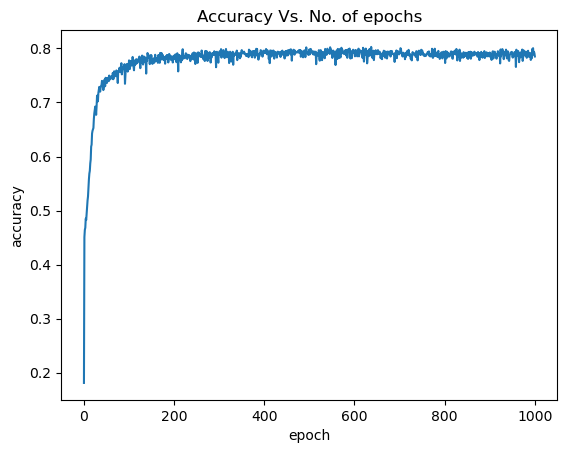

In [478]:
## Replace these values with your result
history = [result0] + history1 #+ history2# + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy Vs. No. of epochs')

In [479]:
torch.save(model, '/home/alex/Documents/NN_path_planning/nn/model/model_v1.pth')

In [448]:
model_1 = torch.load('/home/alex/Documents/NN_path_planning/nn/model/model_v1.pth')

In [449]:
output = model_1.forward(custom_dataset[3230][0])
# _, pred = torch.max(output)
action = F.softmax(output).detach().numpy().argmax()
action

/tmp/ipykernel_10005/1904010061.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action = F.softmax(output).detach().numpy().argmax()


1